In [1]:
#Import Packages
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import zscore
from scipy.stats import norm
from scipy import stats
import os
from os import walk
import glob
import re

from itertools import combinations
from itertools import combinations_with_replacement
from itertools import product

import matplotlib.pyplot as pl
import scanpy as sc

#sc settings
sc.settings.verbosity = False 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save=300)  # low dpi (dots per inch) yields small inline figures

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
cffi                        1.15.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.0
defusedxml                  0.7.1
entrypoints   

In [2]:
def save_for_overlay(datafr, clust, sample_name, filename):  
    df_ov=datafr[[clust, 'sample_name', 'region', 'x', 'y', 'Xcorr', 'Ycorr']]
    df_ov_samp=df_ov[(df_ov['sample_name'].isin([sample_name]))]

    df_ov_samp.to_csv('H:/Marc/Lymphoma_TMA_191_analysis/clustering_output/demonstration_HD/overlays/'+filename+"_"+sample_name+".csv")

In [3]:
def adata_to_dataframe(adata):
    df_var = adata.to_df()
    df_obs = adata.obs
    df = pd.concat([df_var,df_obs], axis=1)
    return df

In [4]:
def cell_thres(data, cell_type, marker_name, cell_marker, cell_col, neg_cell = 'tumor', vmax = 5):
    #Look at plots for pos and neg separation
    #make subset for cluster_num
    data_subset = data[data.obs[cell_col] == cell_type]
    #negative population
    neg = data[data.obs[cell_col] == neg_cell]
    #scatter for pos and neg
    sc.pl.scatter(neg, x=cell_marker, y=marker_name)
    sc.pl.scatter(data_subset, x=cell_marker, y=marker_name)
    #heatmap for every cell expression
    sc.pl.heatmap(data_subset, var_names=data.var_names, vmax=vmax, figsize=(20,5), show_gene_labels=True, groupby='leiden')

In [5]:
def cell_stat(data, cell_type, marker_name, threshold, pos_cntrl, neg_cntrl, cell_col, log_plot=False):
    #Convert to dataframe
    df_var = data.to_df()
    df_obs = data.obs
    df = df_var.merge(df_obs, left_index=True, right_index=True)
    #Subset based on cell types
    cell_sub = df[df[cell_col]==cell_type]
    pos_sub = df[df[cell_col]==pos_cntrl]
    neg_sub = df[df[cell_col]==neg_cntrl]
    #Calculate stats
    per_10 = cell_sub[marker_name].quantile(0.10)
    per_90 = cell_sub[marker_name].quantile(0.90)
    med = cell_sub[marker_name].median()
    mean = cell_sub[marker_name].mean()
    thres = stats.percentileofscore(cell_sub[marker_name],threshold)
    pos_thres = stats.percentileofscore(pos_sub[marker_name],threshold)
    neg_thres = stats.percentileofscore(neg_sub[marker_name],threshold)
    #Print stats
    print('10% = '+str(per_10) +'\n'
         '90% = '+str(per_90) +'\n'
         'median = '+str(med) +'\n'
         'mean = '+str(mean) +'\n'
         'threshold = '+str(100-thres) +'\n'
         'pos_thres = '+str(100-pos_thres) +'\n'
         'neg_thres = '+str(100-neg_thres) +'\n')
    #Plot histogram
    cell_sub[marker_name].plot.hist(bins=100, alpha=0.8,logy = log_plot)

In [6]:
def cell_split(data, cell_type, marker_name, threshold, cell_col, new_cell_col, neg_cat, pos_cat, overlay):
    #subset a given cluster
    clust_sub = data[(data.obs[cell_col] == cell_type)]
    df_clust_sub=adata_to_dataframe(clust_sub)
    #subset based on a marker
    df_clust_sub[new_cell_col]=df_clust_sub[new_cell_col].astype('object')
    df_clust_sub.loc[df_clust_sub[marker_name] <= threshold, new_cell_col] = neg_cat
    df_clust_sub.loc[df_clust_sub[marker_name] > threshold, new_cell_col] = pos_cat
    df_clust_sub[new_cell_col]=df_clust_sub[new_cell_col].astype('category')
    #See number of cells in each type
    print(df_clust_sub.groupby(new_cell_col)['region'].count())
    #save .csv for overlay
    df_overlay=df_clust_sub[[new_cell_col, 'unique_cell_id', 'sample_name', 'region', 'leiden', 'x', 'y', 'Xcorr', 'Ycorr']]
    filename=new_cell_col+'_'+cell_type
    for element in overlay:
        save_for_overlay(df_overlay, new_cell_col, element, filename)
    df_return=df_clust_sub[['unique_cell_id', new_cell_col]]
    return df_return

In [7]:
def cell_split_2(data, cell_type, marker_name, marker_name2, threshold, thres2, cell_col, new_cell_col, neg_cat, pos_cat, overlay):
    #subset a given cluster
    adata_cpy=data.copy()
    clust_sub = adata_cpy[(adata_cpy.obs[cell_col] == cell_type)]
    #subset based on a marker
    neg = clust_sub[~((clust_sub[:, [marker_name]].X > threshold)&(clust_sub[:, [marker_name2]].X < thres2))]
    pos = clust_sub[((clust_sub[:, [marker_name]].X > threshold)&(clust_sub[:, [marker_name2]].X < thres2))]
    #Create a list together based on unique_cell_id
    neg_list = list(neg.obs.unique_cell_id)
    pos_list = list(pos.obs.unique_cell_id)
    #Assign new cell type label based on separation
    clust_sub.obs[new_cell_col]=clust_sub.obs[new_cell_col].astype('object')
    clust_sub.obs.loc[clust_sub.obs.unique_cell_id.isin(neg_list), new_cell_col]  = neg_cat
    clust_sub.obs.loc[clust_sub.obs.unique_cell_id.isin(pos_list), new_cell_col]  = pos_cat
    clust_sub.obs[new_cell_col]=clust_sub.obs[new_cell_col].astype('category')
    #See number of cells in each type
    #convert to dataframe 
    df_clust_sub=adata_to_dataframe(clust_sub)
    #save .csv for overlay
    df_overlay=df_clust_sub[[new_cell_col, 'unique_cell_id', 'sample_name', 'region', 'leiden', 'x', 'y', 'Xcorr', 'Ycorr']]
    filename=new_cell_col+'_'+cell_type
    for element in overlay:
        save_for_overlay(df_overlay, new_cell_col, element, filename)
    #return reduced version of df
    df_return=df_clust_sub[['unique_cell_id', new_cell_col]]
    print(df_return.groupby(new_cell_col)['unique_cell_id'].count())
    return df_return

In [8]:
def subcluster(anndata, cluster, omit_mark, new_clust_name, res, overlay):
    #create sub-anndata that contains only cluster to subcluster
    adata_cpy=anndata.copy()
    adata_sub=adata_cpy[adata_cpy.obs[new_clust_name].isin([cluster])]
    #Select markers to cluster on
    list_markers_tmp = [x for x in list_var]
    for marker in omit_mark:
        list_markers_tmp.remove(marker)
    #create sub_anndata that contains only markers wanted for clustering
    df_tmp=adata_to_dataframe(adata_sub)
    df_tmp_2=df_tmp[list_markers_tmp]
    adata_sub_2=sc.AnnData(df_tmp_2)
    adata_sub_2.obs=df_tmp[['unique_cell_id', 'sample_name', 'region', 'leiden', 'x', 'y', 'Xcorr', 'Ycorr']]
    #Compute the neighborhood relations of single cells.
    sc.pp.neighbors(adata_sub_2, n_neighbors=10)
    #Perform leiden clustering - improved version of louvain clustering
    sc.tl.leiden(adata_sub_2, resolution=res, key_added = new_clust_name)
    #UMAP computation
    sc.tl.umap(adata_sub_2)
    sc.pl.umap(adata_sub_2, color=[new_clust_name])
    #Create matrix plot with mean expression per each cluster
    sc.pl.dotplot(adata_sub_2, list_markers_tmp, new_clust_name, expression_cutoff=0.33, vmax=3)
    #list number of cells per cluster
    print(adata_sub_2.obs.groupby([new_clust_name])['unique_cell_id'].count().sort_values())
    #show which coverlsips are enriched for which clusters
    #See number in each cluster by sample
    percent = adata_sub_2.obs.groupby(['sample_name',new_clust_name])['region'].count().unstack()
    percent.columns = percent.columns.add_categories('total')
    percent['total'] = percent.sum(axis=1)
    print(percent)
    percent2 = percent.apply(lambda x:x/percent.total)
    percent2.columns = percent2.columns.astype(str)
    percent2.index = percent2.index.astype(str)
    percent2.loc['Total',:]= percent2.sum(axis=0)
    percent3 =  percent2.apply(lambda x:x/percent2.loc['Total',:], axis=1)
    pl.figure(figsize=(15, 10))
    sns.heatmap(data=percent3)
    #save .csv for overlay
    df_overlay=adata_sub_2.obs[[new_clust_name, 'unique_cell_id', 'sample_name', 'region', 'leiden', 'x', 'y', 'Xcorr', 'Ycorr']]
    filename=new_clust_name+cluster
    for element in overlay:
        save_for_overlay(df_overlay, new_clust_name, element, filename)
    df_return=adata_sub_2.obs[['unique_cell_id', new_clust_name]]
    rdf_return=df_return.rename(columns={new_clust_name: new_clust_name+'_numb'})
    return df_return

In [9]:
def save_subclust (df, clust_col, dict_annot, filename):
    name_col=clust_col+'_names'
    numb_col=clust_col+'_numb'
    df[name_col] = df[clust_col].map(dict_annot).astype('category')
    df=df.rename(columns={clust_col: numb_col})
    df=df.rename(columns={name_col: clust_col})
    df.to_csv('H:/Marc/Lymphoma_TMA_191_analysis/clustering_output/demonstration_HD/subclusters/'+clust_col+'/'+filename+'.csv')

In [10]:
def gather_subclusters(anndata, subcl, path, old_clust_col, new_clust_col, next_clust_col):
    df_obs=anndata.obs
    df_obs_rest=df_obs[~df_obs[old_clust_col].isin(subcl)]
    df_obs_rest=df_obs_rest[['unique_cell_id', new_clust_col]]
    filelist=[]
    for (dirpath,dirnames,filenames) in walk(path):
        filelist.extend(filenames)
        break
    df_subclust_list=[]
    for file in filelist:
        df_subclust_list.append(pd.read_csv(path+'//'+file))
    df_subclust=pd.concat(df_subclust_list)
    df_concat=pd.concat([df_obs_rest, df_subclust])
    #CHANGE PATH WHEN RUNNING ON NEW DATASET
    df_concat.to_csv(r'H:\Marc\Lymphoma_TMA_191_analysis\clustering_output\demonstration_HD\subclusters\\'+new_clust_col+'.csv')
    df_concat_2=df_concat[['unique_cell_id', new_clust_col]]
    df_concat_2.index = df_concat.index.map(str)
    anndata.obs=anndata.obs.drop([new_clust_col], axis=1)
    anndata.obs=anndata.obs.merge(df_concat_2, on='unique_cell_id')
    anndata.obs[new_clust_col]=anndata.obs[new_clust_col].astype('category')
    anndata.obs[next_clust_col] = anndata.obs[new_clust_col].astype(str)
    anndata.obs_names_make_unique()
    #create overlays for validation
    df_overl=anndata.obs[[new_clust_col, 'sample_name', 'region', 'x', 'y', 'Xcorr', 'Ycorr']]
    for sample in anndata.obs['sample_name'].unique():
        save_for_overlay(df_overl, new_clust_col, sample, new_clust_col)
    return anndata

In [11]:
def plot_clusters(anndata, subset_list, clust_col, cutoff):
    anndata_subset = anndata[anndata.obs[clust_col].isin(subset_list)]
    m_list=list_var
    sc.pl.dotplot(anndata_subset, m_list, clust_col, expression_cutoff=cutoff, vmax=3)
    percent = anndata_subset.obs.groupby(['sample_name',clust_col])['region'].count().unstack()
    percent.columns = percent.columns.add_categories('total')
    percent['total'] = percent.sum(axis=1)
    print(percent)
    percent2 = percent.apply(lambda x:x/percent.total)
    percent2.columns = percent2.columns.astype(str)
    percent2.index = percent2.index.astype(str)
    percent2.loc['Total',:]= percent2.sum(axis=0)
    percent3 =  percent2.apply(lambda x:x/percent2.loc['Total',:], axis=1)
    pl.figure(figsize=(15, 10))
    subset_list.append('total')
    sns.heatmap(data=percent3)

In [12]:
list_var=['PAX5', 'FOXP3', 'CD45', 'CD20', 'CD79a', 'CD21', 'CD38', 'lambda',
       'kappa', 'CD3', 'CD7', 'CD5', 'CD4', 'CD8', 'CD56', 'CD57', 'CD25',
       'CD11b', 'CD15', 'CD14', 'CD16', 'CD68', 'CD163', 'CD206', 'CD11c',
       'MCT', 'CD34', 'CD31', 'CD90', 'PDPN', 'HLA-DR']

In [13]:
df=pd.read_csv(r'H:\Marc\Lymphoma_TMA_191_analysis\clustering_output\demonstration_HD\Expression_data_191_3_reg007.csv')
df=df.drop(['Unnamed: 0'], axis=1)
df

,PAX5,FOXP3,CD45,CD20,CD79a,CD21,CD38,lambda,kappa,CD3,...,y,size,sample_name,unique_region,unique_cell_id,leiden,Xcorr,Ycorr,y_inv,cluster_names
0,-0.343220,-0.203223,-0.819914,-0.445263,-0.485965,-0.276689,-0.851925,-0.236295,-0.473789,-0.691856,...,2517.0,255.0,191_3,191_3reg007,191_3_7_1,28,6903.0,25017.0,4983.0,B_6
1,-0.274827,-0.270391,-0.727330,-0.415309,-0.568078,-0.261464,-1.010171,-0.301919,0.091905,-0.292935,...,523.0,131.0,191_3,191_3reg007,191_3_7_2,3,7722.0,23023.0,6977.0,CD4T_mix
2,-0.818941,0.016972,-0.130229,0.020957,0.552179,-0.303769,3.210893,0.135828,7.062912,-0.560977,...,1497.0,119.0,191_3,191_3reg007,191_3_7_3,9,3531.0,23997.0,6003.0,plasma_tumor?
3,-0.757550,-0.280165,-0.297866,-0.797222,-0.674194,-0.312857,1.044614,-0.118851,1.598930,-0.595747,...,5276.0,109.0,191_3,191_3reg007,191_3_7_4,9,4672.0,27776.0,2224.0,plasma_tumor?
4,-0.399738,-0.214835,1.934452,4.343739,0.505660,1.252649,1.138176,0.246778,0.532301,-0.410657,...,3079.0,115.0,191_3,191_3reg007,191_3_7_5,22,7017.0,25579.0,4421.0,B_CD4T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129087,-0.785922,2.457263,-0.674837,-0.743532,-0.681693,-0.208121,-0.024963,0.090313,0.415189,0.681334,...,7203.0,313.0,191_3,191_3reg007,191_3_7_129884,2,6703.0,29703.0,297.0,Treg
129088,-0.728879,-0.019602,0.059265,-0.531803,-0.667694,-0.232384,0.037492,0.238246,0.846259,0.736594,...,5359.0,251.0,191_3,191_3reg007,191_3_7_129885,39,7993.0,27859.0,2141.0,moise_plasma_T_CD16
129089,-0.770652,-0.076137,-0.265172,-0.687864,-0.705896,-0.254361,-0.328207,-0.136506,-0.235093,1.217765,...,6694.0,265.0,191_3,191_3reg007,191_3_7_129886,39,5165.0,29194.0,806.0,moise_plasma_T_CD16
129090,-0.742637,-0.119353,0.371313,-0.534545,-0.671131,-0.211797,0.330467,0.105875,0.311443,3.134537,...,1824.0,285.0,191_3,191_3reg007,191_3_7_129887,42,9569.0,24324.0,5676.0,mast


In [14]:
list_obs=[x for x in df.columns if x not in list_var]
list_obs

['Ki67',
 'BCL6',
 'CD103',
 'Myc',
 'CD39',
 'pSTAT3',
 'CD70',
 'GATA3',
 'CXCR5',
 'Tbet',
 'CD62L',
 'CD194',
 'TIM3',
 'CD134',
 'IL10',
 'blank24',
 'CTLA4',
 'blank25',
 'CXCL13',
 'PD1',
 'LAG3',
 'blank37',
 'CD45RO',
 'ICOS',
 'CD69',
 'CD45RA',
 'GRZB',
 'CD44',
 'Hoechst1',
 'DRAQ5',
 'region',
 'x',
 'y',
 'size',
 'sample_name',
 'unique_region',
 'unique_cell_id',
 'leiden',
 'Xcorr',
 'Ycorr',
 'y_inv',
 'cluster_names']

In [15]:
adata = sc.AnnData(df[list_var])
adata.obs = df[list_obs]
adata.obs['leiden']=adata.obs['leiden'].astype('str')
adata

C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\Marc\AppData\Local\Temp\6/ipykernel_14876/3904479115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['leiden']=adata.obs['leiden'].astype('str')


AnnData object with n_obs × n_vars = 129092 × 31
    obs: 'Ki67', 'BCL6', 'CD103', 'Myc', 'CD39', 'pSTAT3', 'CD70', 'GATA3', 'CXCR5', 'Tbet', 'CD62L', 'CD194', 'TIM3', 'CD134', 'IL10', 'blank24', 'CTLA4', 'blank25', 'CXCL13', 'PD1', 'LAG3', 'blank37', 'CD45RO', 'ICOS', 'CD69', 'CD45RA', 'GRZB', 'CD44', 'Hoechst1', 'DRAQ5', 'region', 'x', 'y', 'size', 'sample_name', 'unique_region', 'unique_cell_id', 'leiden', 'Xcorr', 'Ycorr', 'y_inv', 'cluster_names'

In [19]:
adata.obs

,Ki67,BCL6,CD103,Myc,CD39,pSTAT3,CD70,GATA3,CXCR5,Tbet,...,y,size,sample_name,unique_region,unique_cell_id,leiden,Xcorr,Ycorr,y_inv,cluster_names
0,-0.401533,338.031374,456.239218,287.098040,443.407844,290.831372,414.003920,398.623527,471.168629,650.525489,...,2517.0,255.0,191_3,191_3reg007,191_3_7_1,28,6903.0,25017.0,4983.0,B_6
1,3.580222,1750.072307,525.104944,816.800282,481.760356,252.827754,631.869556,227.995458,1023.333263,3491.047967,...,523.0,131.0,191_3,191_3reg007,191_3_7_2,3,7722.0,23023.0,6977.0,CD4T_mix
2,-0.400583,1669.949587,1019.092442,986.386558,1354.739499,809.344537,886.067223,446.537812,1442.537820,2562.134449,...,1497.0,119.0,191_3,191_3reg007,191_3_7_3,9,3531.0,23997.0,6003.0,plasma_tumor?
3,2.063002,623.894071,337.193149,439.791717,539.567899,331.896102,577.365390,91.185084,514.844432,492.527084,...,5276.0,109.0,191_3,191_3reg007,191_3_7_4,9,4672.0,27776.0,2224.0,plasma_tumor?
4,-0.403883,761.636404,531.723904,492.519834,465.281829,255.652211,379.300335,657.146533,1757.886398,1521.537907,...,3079.0,115.0,191_3,191_3reg007,191_3_7_5,22,7017.0,25579.0,4421.0,B_CD4T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129087,-0.376794,1303.485629,845.853040,554.610225,936.980833,478.405750,1587.437693,4143.626170,560.907350,1804.207665,...,7203.0,313.0,191_3,191_3reg007,191_3_7_129884,2,6703.0,29703.0,297.0,Treg
129088,-0.373407,1438.079687,869.083670,599.808767,950.828688,736.087649,1791.876487,3809.402365,1271.274905,5372.442222,...,5359.0,251.0,191_3,191_3reg007,191_3_7_129885,39,7993.0,27859.0,2141.0,moise_plasma_T_CD16
129089,-0.390247,1124.056609,725.652834,428.611322,702.309436,352.558490,1441.083013,2046.132062,518.954719,7833.086779,...,6694.0,265.0,191_3,191_3reg007,191_3_7_129886,39,5165.0,29194.0,806.0,moise_plasma_T_CD16
129090,-0.406480,1191.928643,831.223481,561.990284,996.346617,800.354213,1479.862618,4563.393439,634.478856,1934.957927,...,1824.0,285.0,191_3,191_3reg007,191_3_7_129887,42,9569.0,24324.0,5676.0,mast


C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\anndata\_core\anndata.py:1241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'sample_name' as categorical
C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will

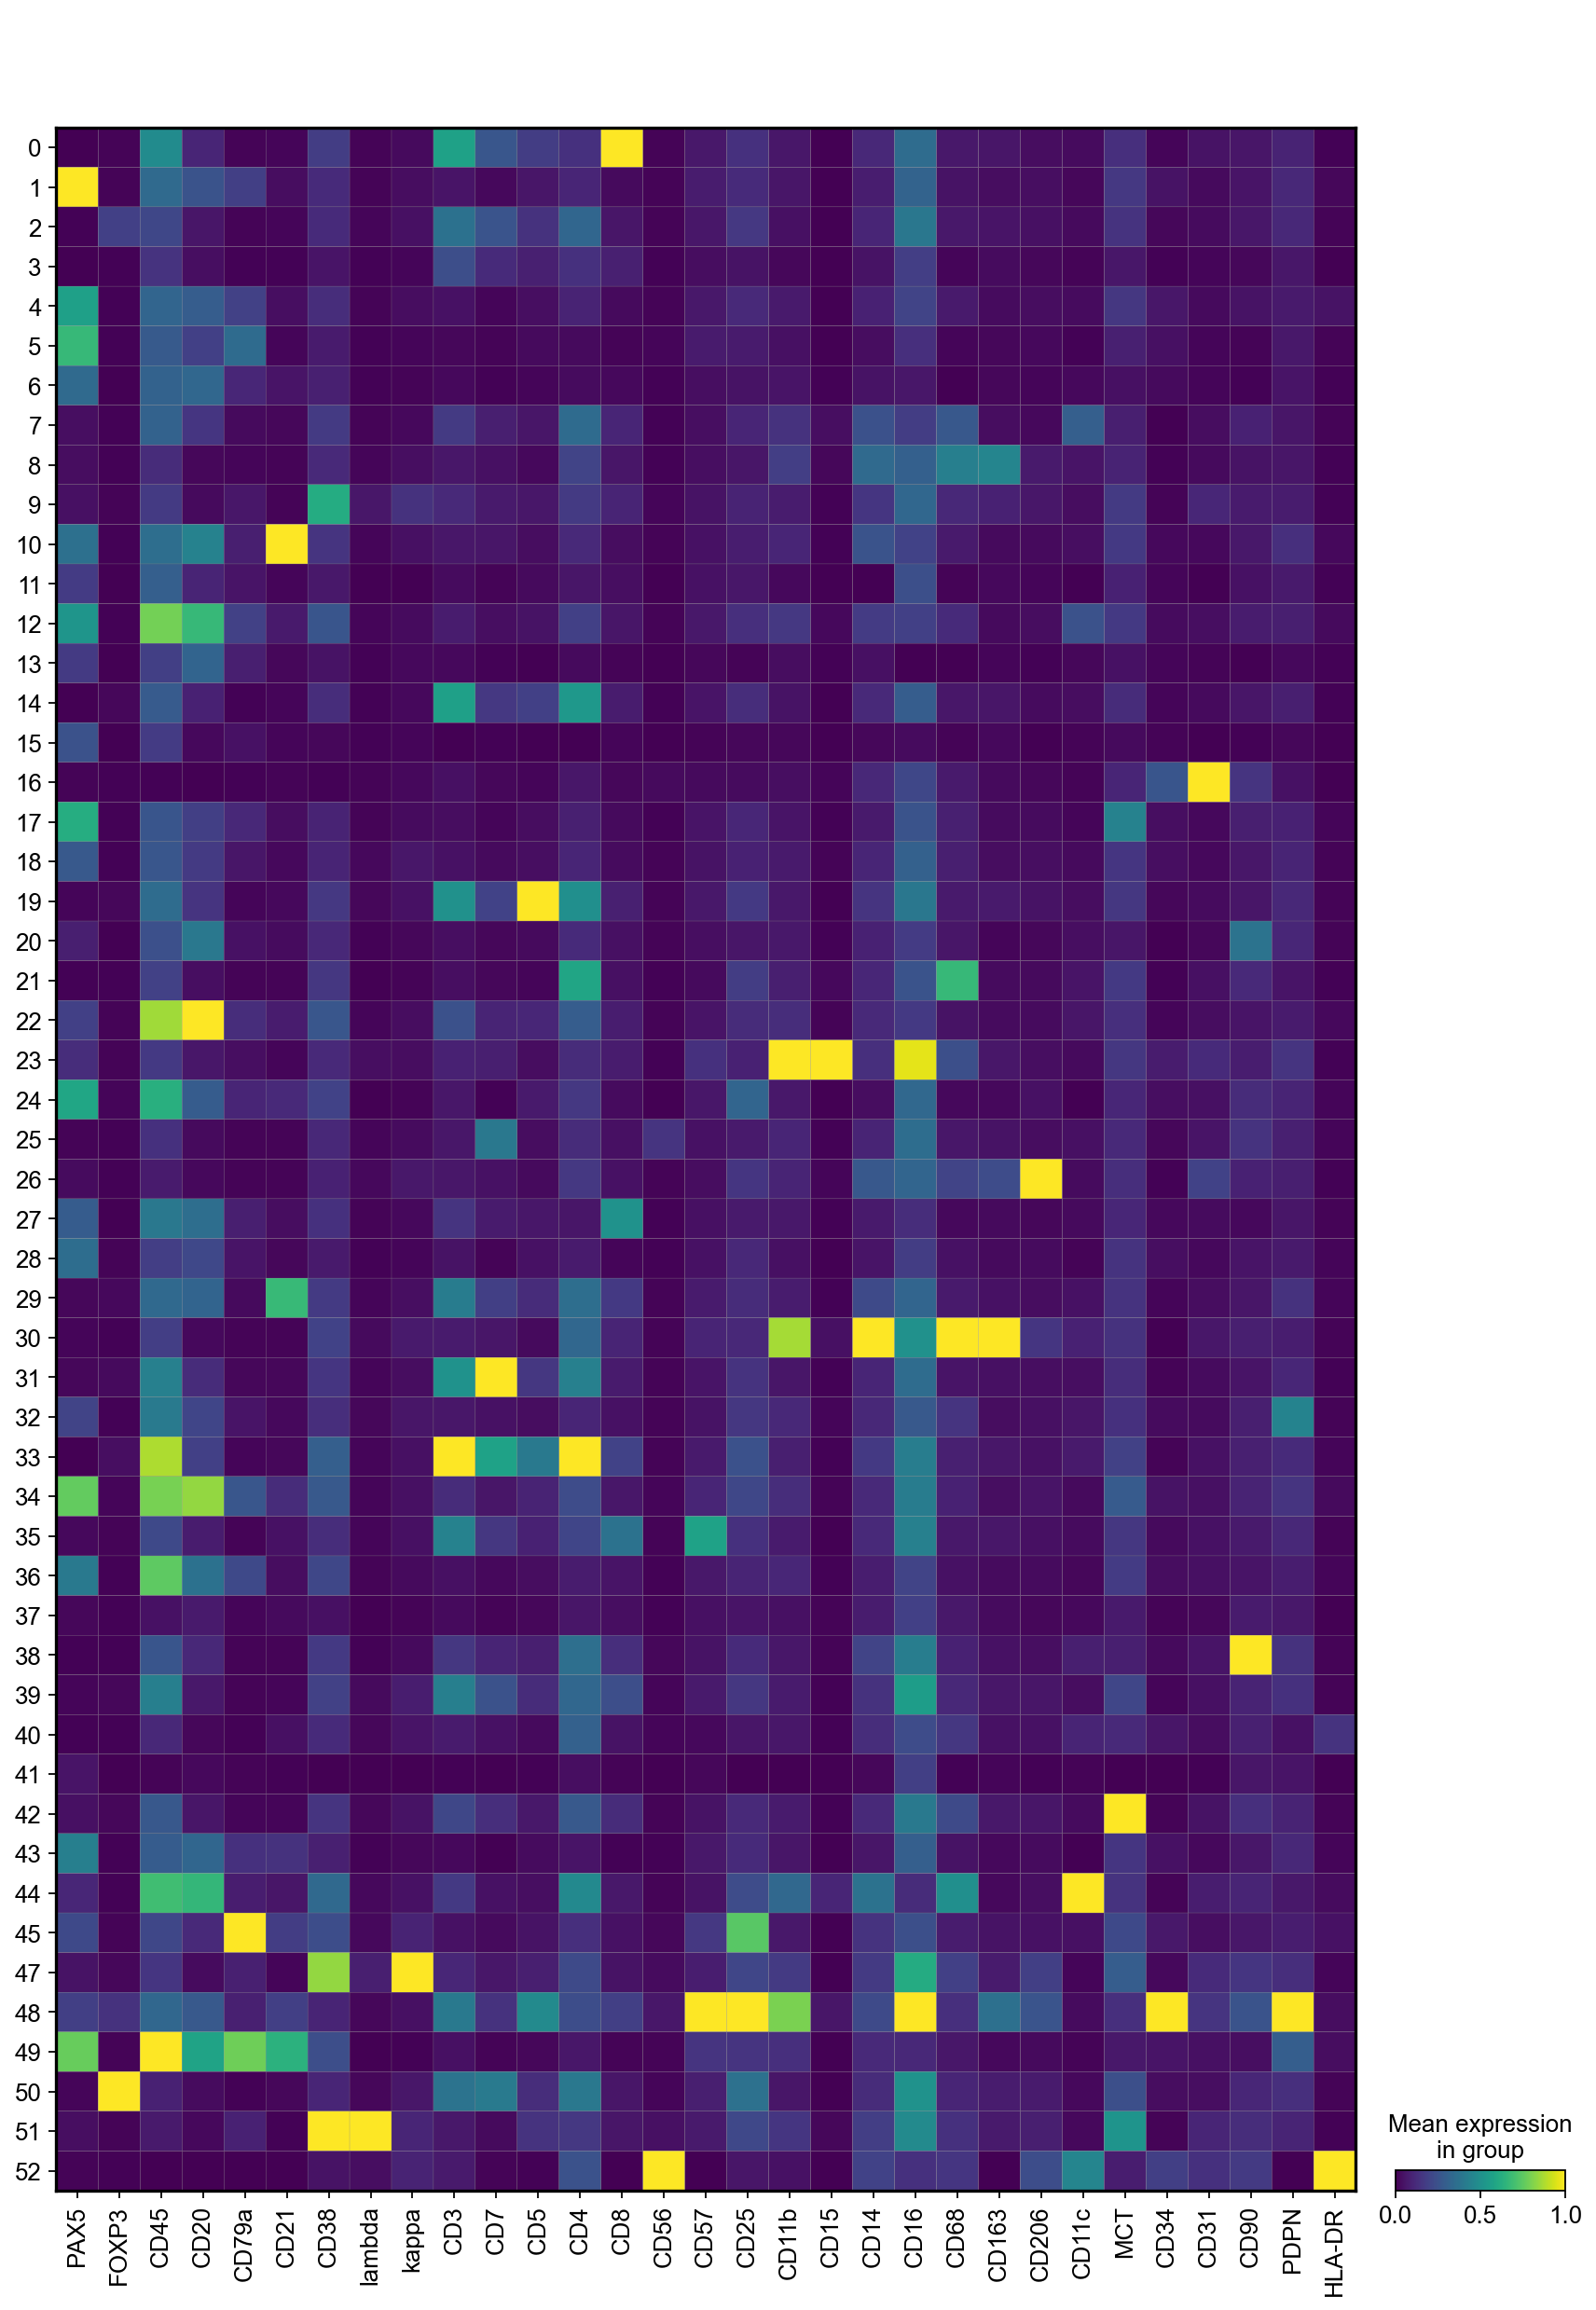

In [16]:
#Create matrix plot with mean expression per each cluster
sc.pl.matrixplot(adata, list_var, 'leiden',standard_scale='var')

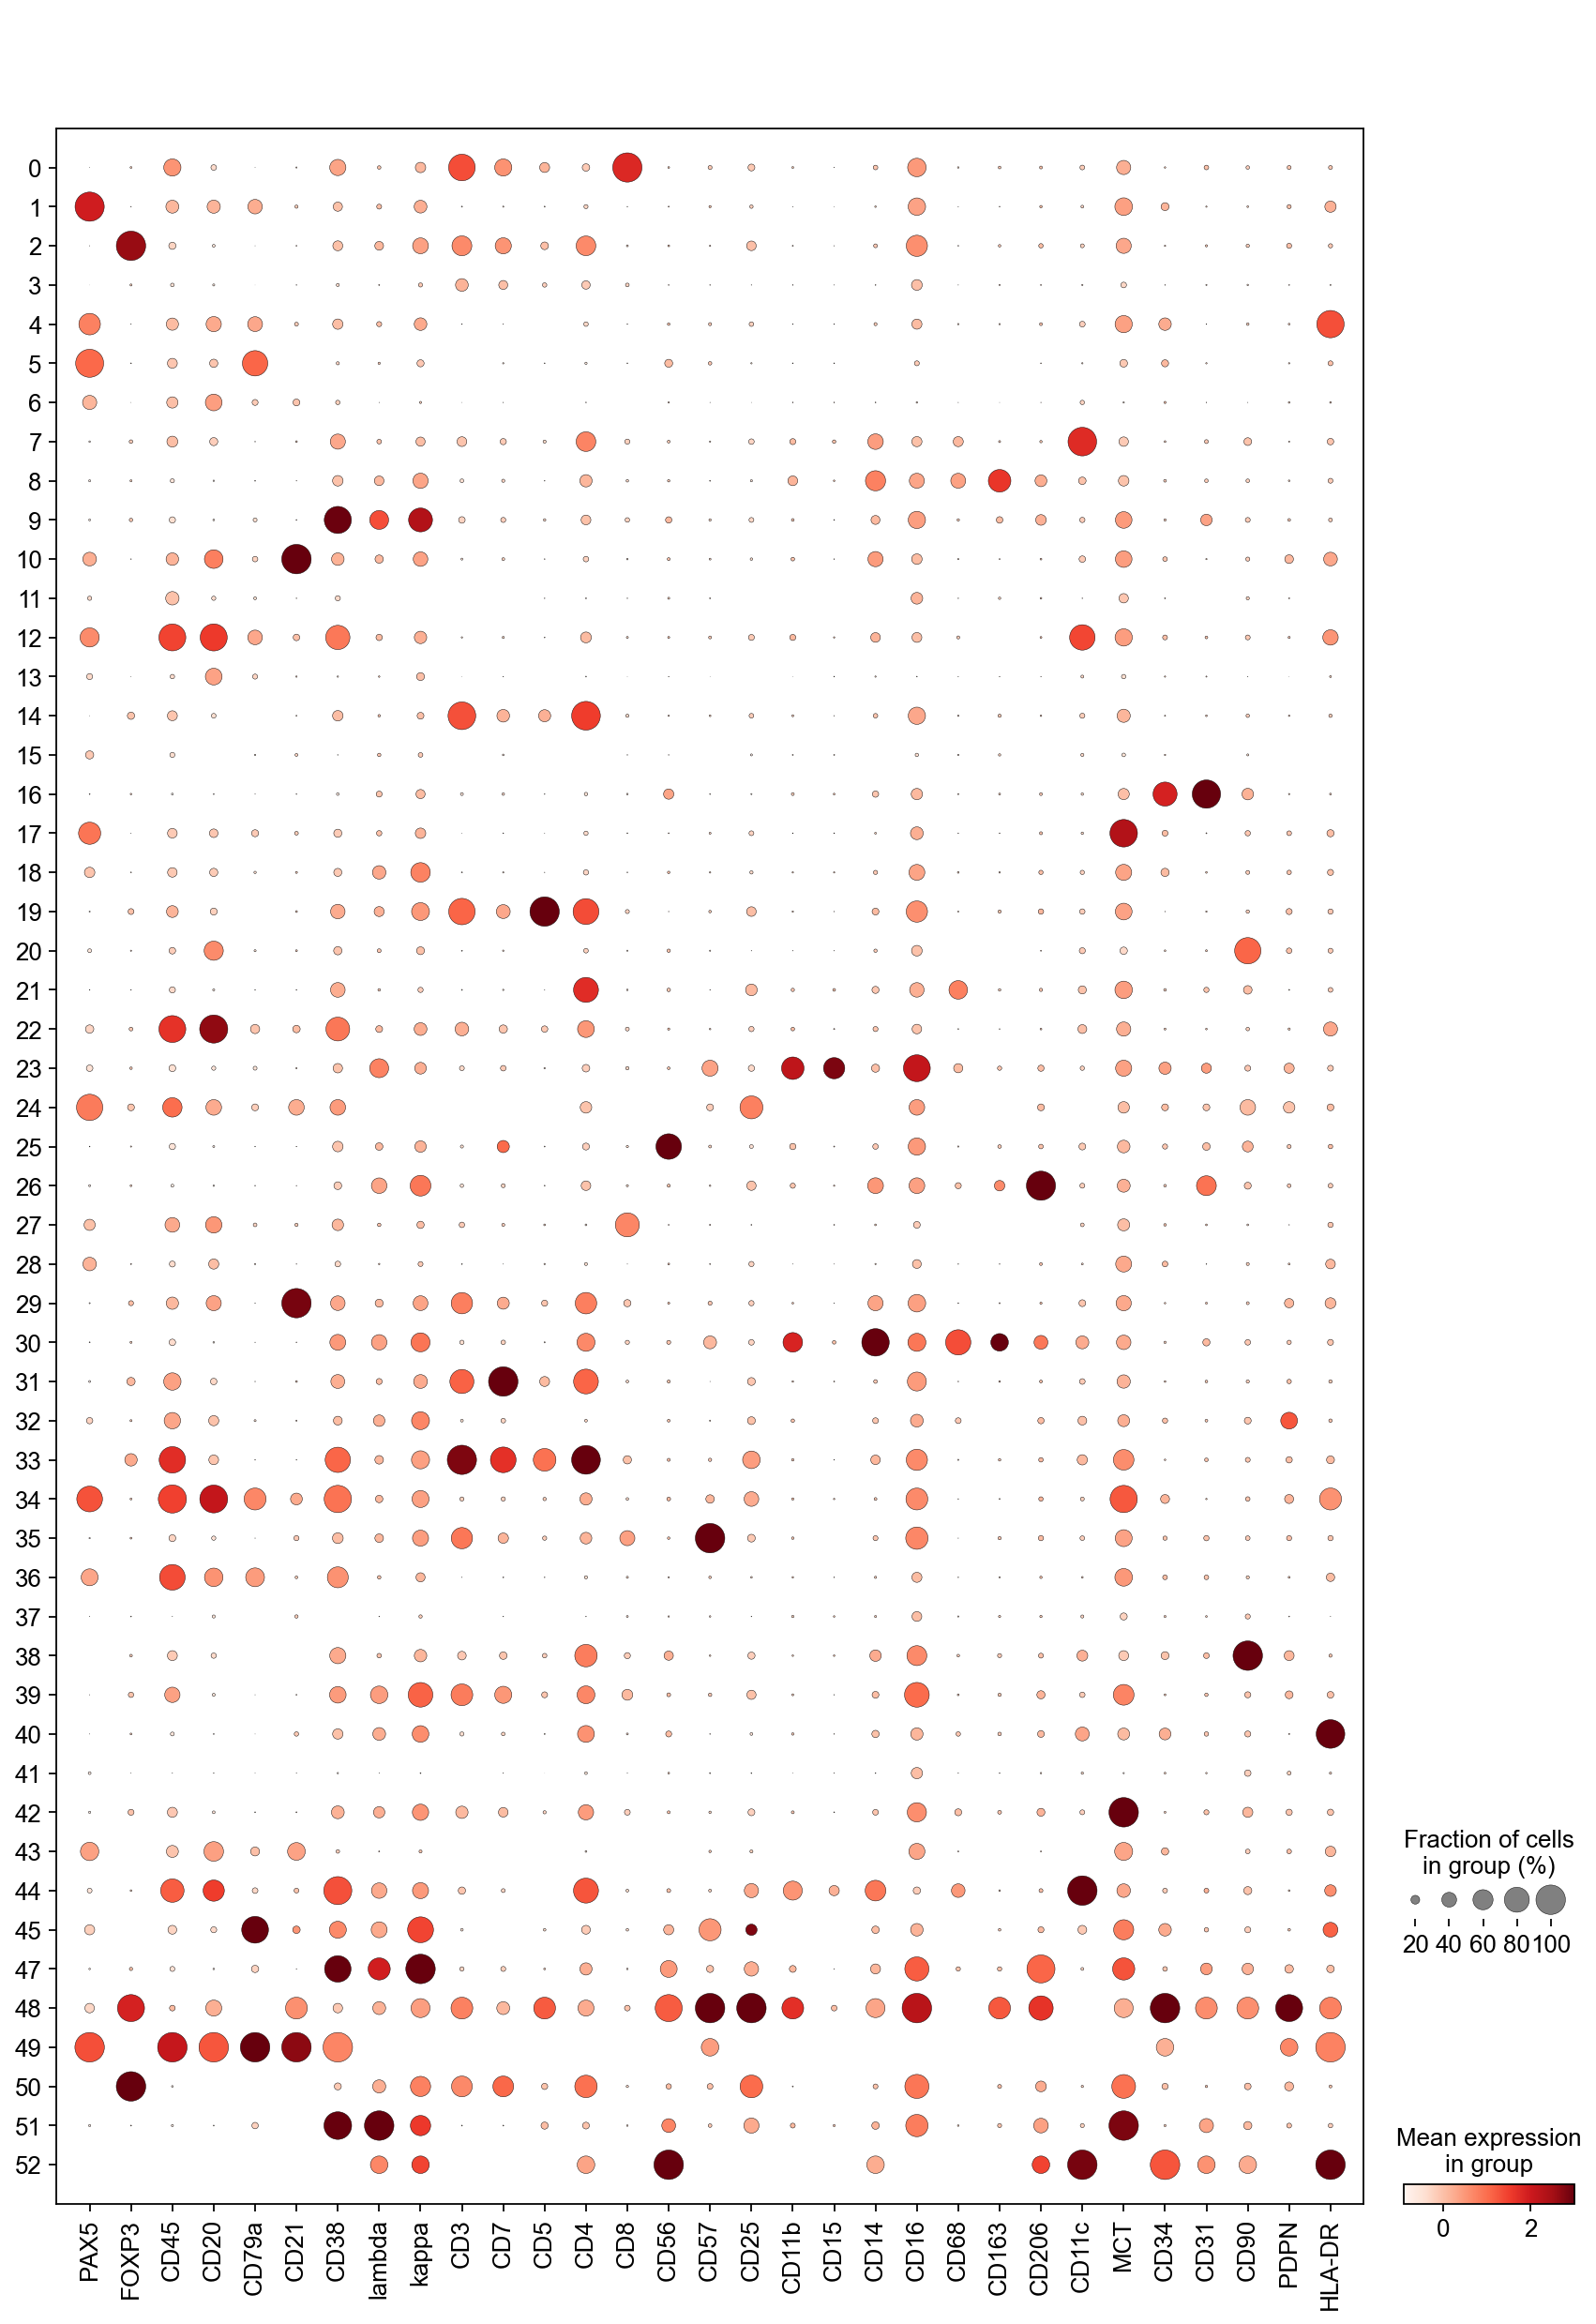

In [17]:
sc.pl.dotplot(adata, list_var, 'leiden', expression_cutoff=0.33, vmax=3)

In [ ]:
cluster_names = {
 '0': '',
 '1': '',
 '2': '',
 '3': '',
 '4': '',
 #...
}

In [ ]:
 #Assigning the clusters to anndata
adata.obs['cluster_names'] = (adata.obs['leiden'].map(cluster_names).astype('category'))
adata.obs

In [18]:
save_for_overlay(df, 'leiden', '191_3', 'prim_clust')

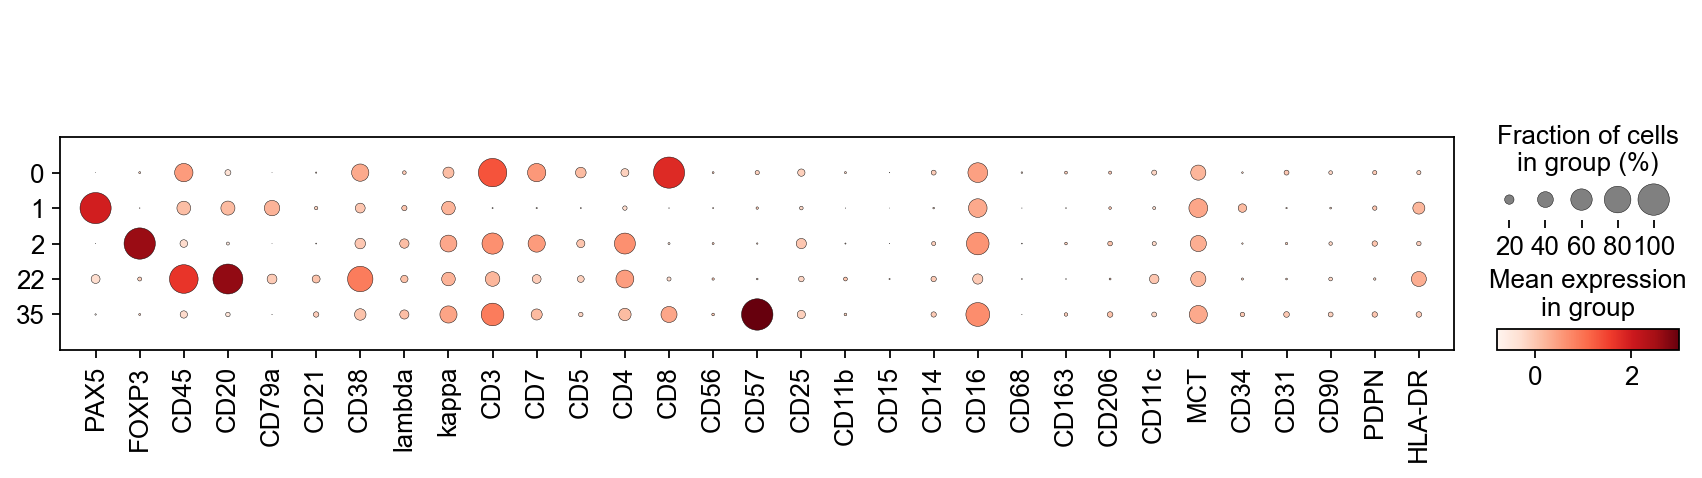

leiden          0     1     2    22   35  total
sample_name                                    
191_3        1269  4578  7740  1082  321  14990


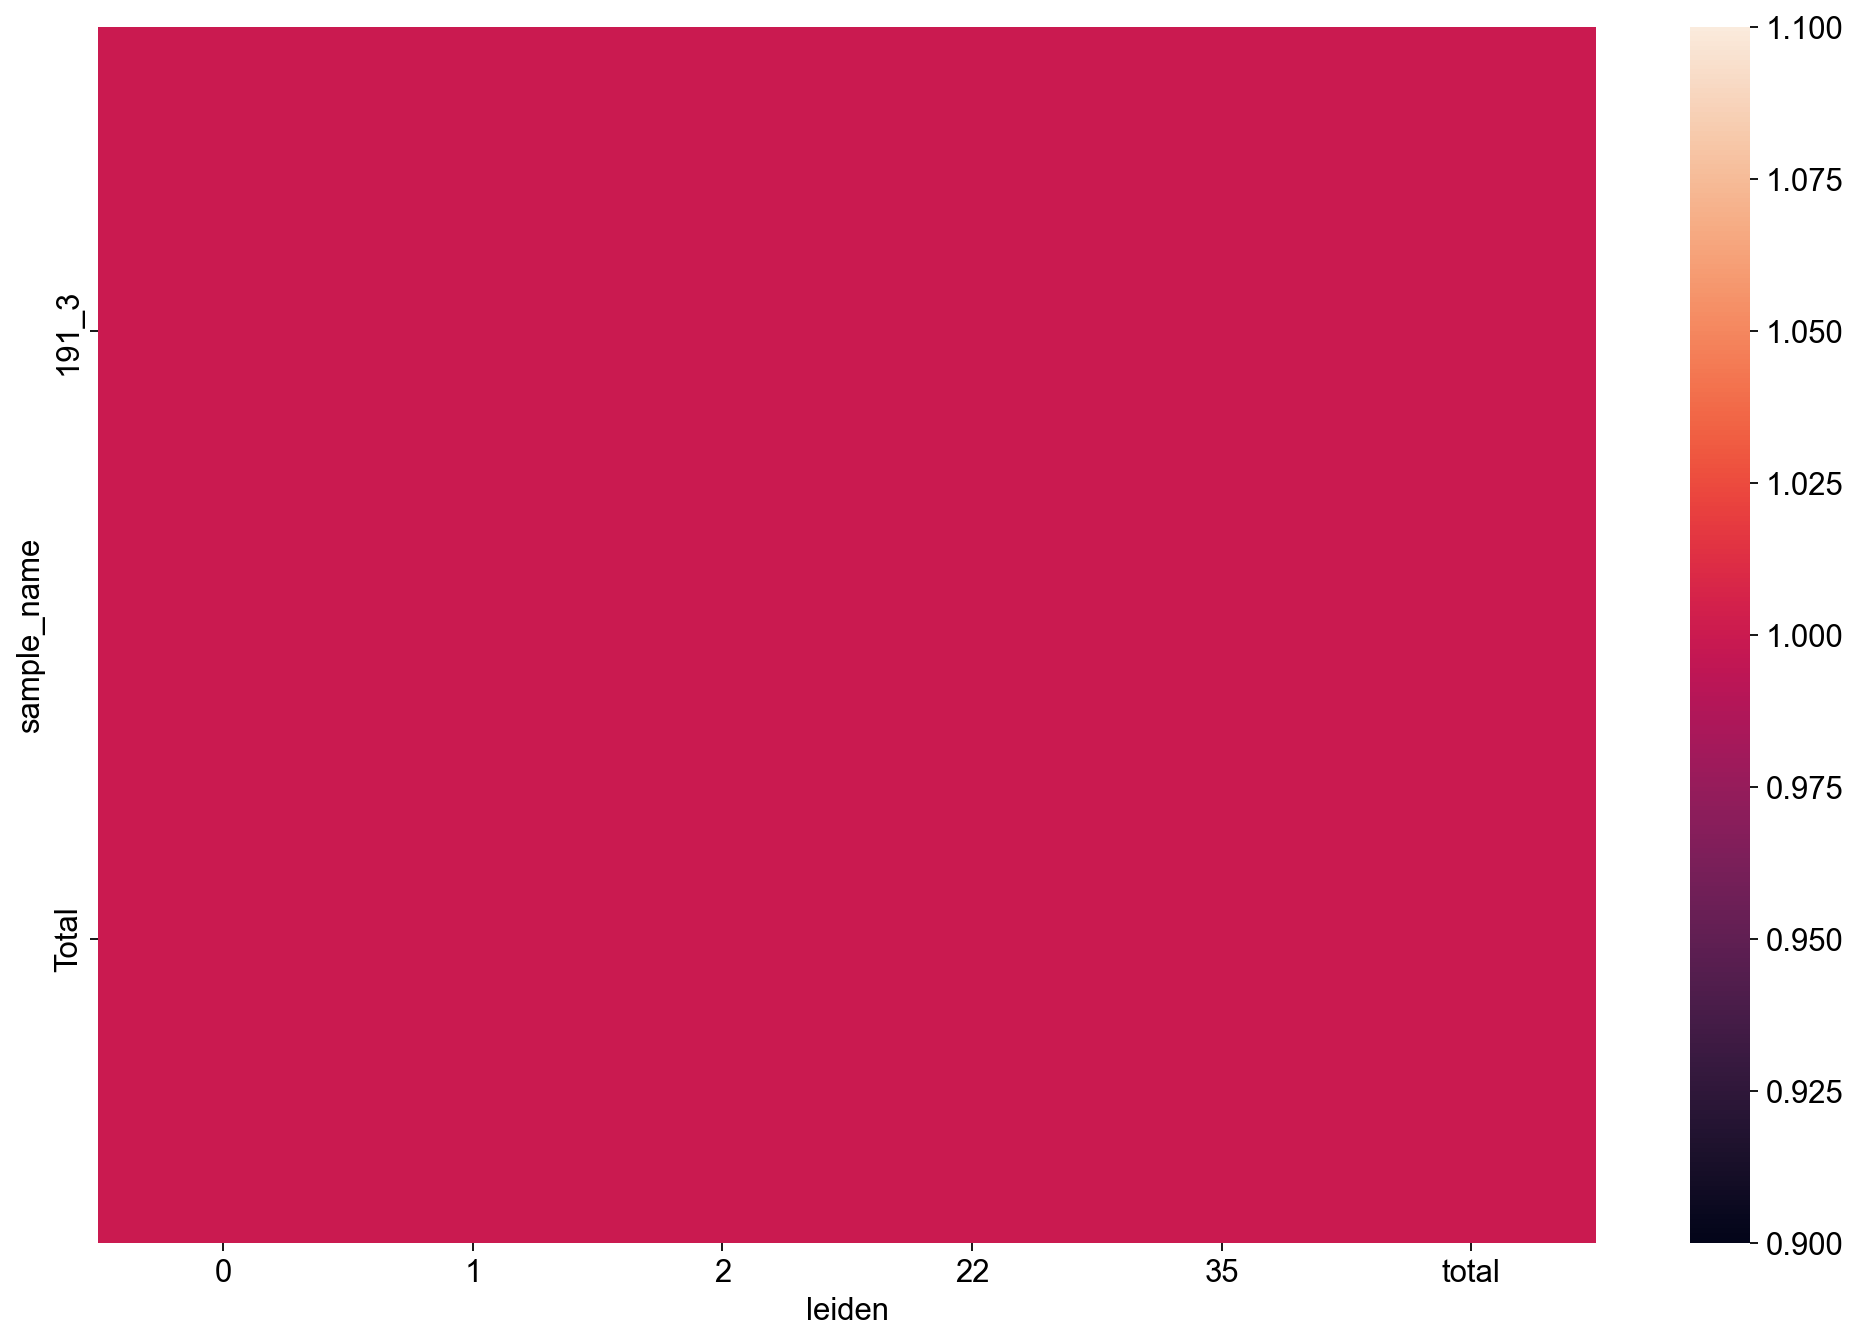

In [20]:
plot_clusters(anndata=adata, subset_list=['0', '1', '2', '22', '35'], clust_col='leiden', cutoff=0.33)

In [21]:
adata.obs['subcluster']=adata.obs['leiden']

C:\Users\Marc\AppData\Local\Temp\6/ipykernel_14876/2094869521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['subcluster']=adata.obs['leiden']


C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\scanpy\tools\_leiden.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[key_added] = pd.Categorical(


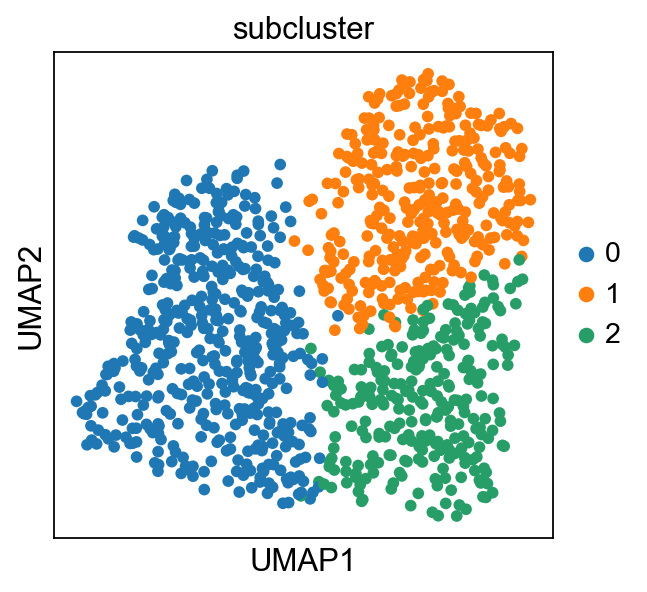

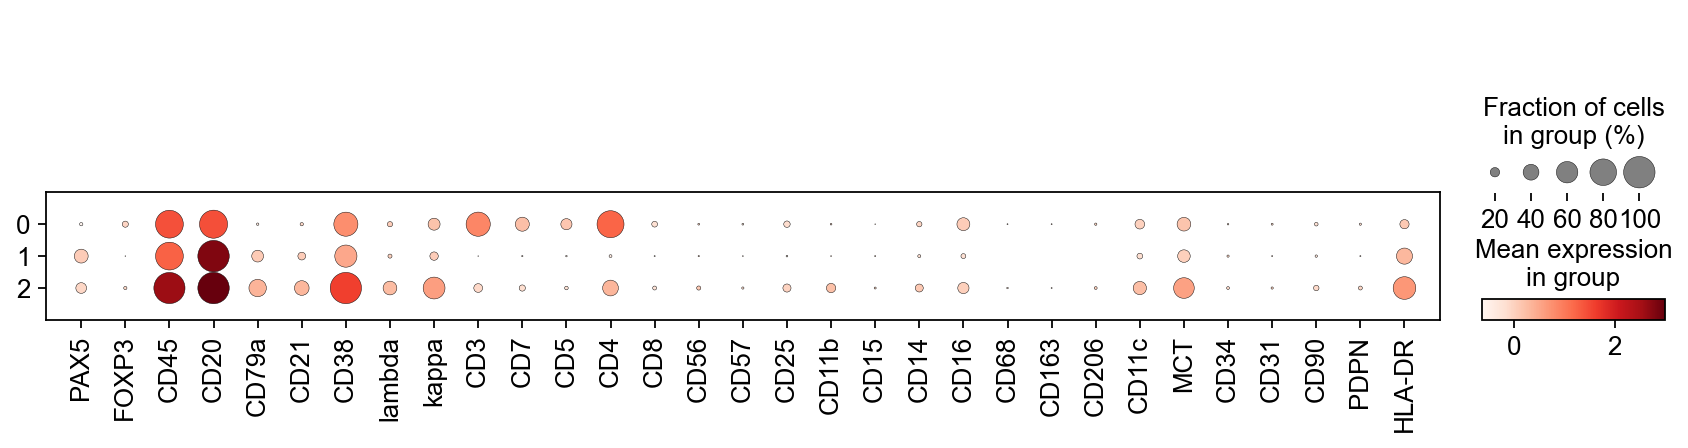

subcluster
2    268
1    336
0    478
Name: unique_cell_id, dtype: int64
subcluster     0    1    2  total
sample_name                      
191_3        478  336  268   1082


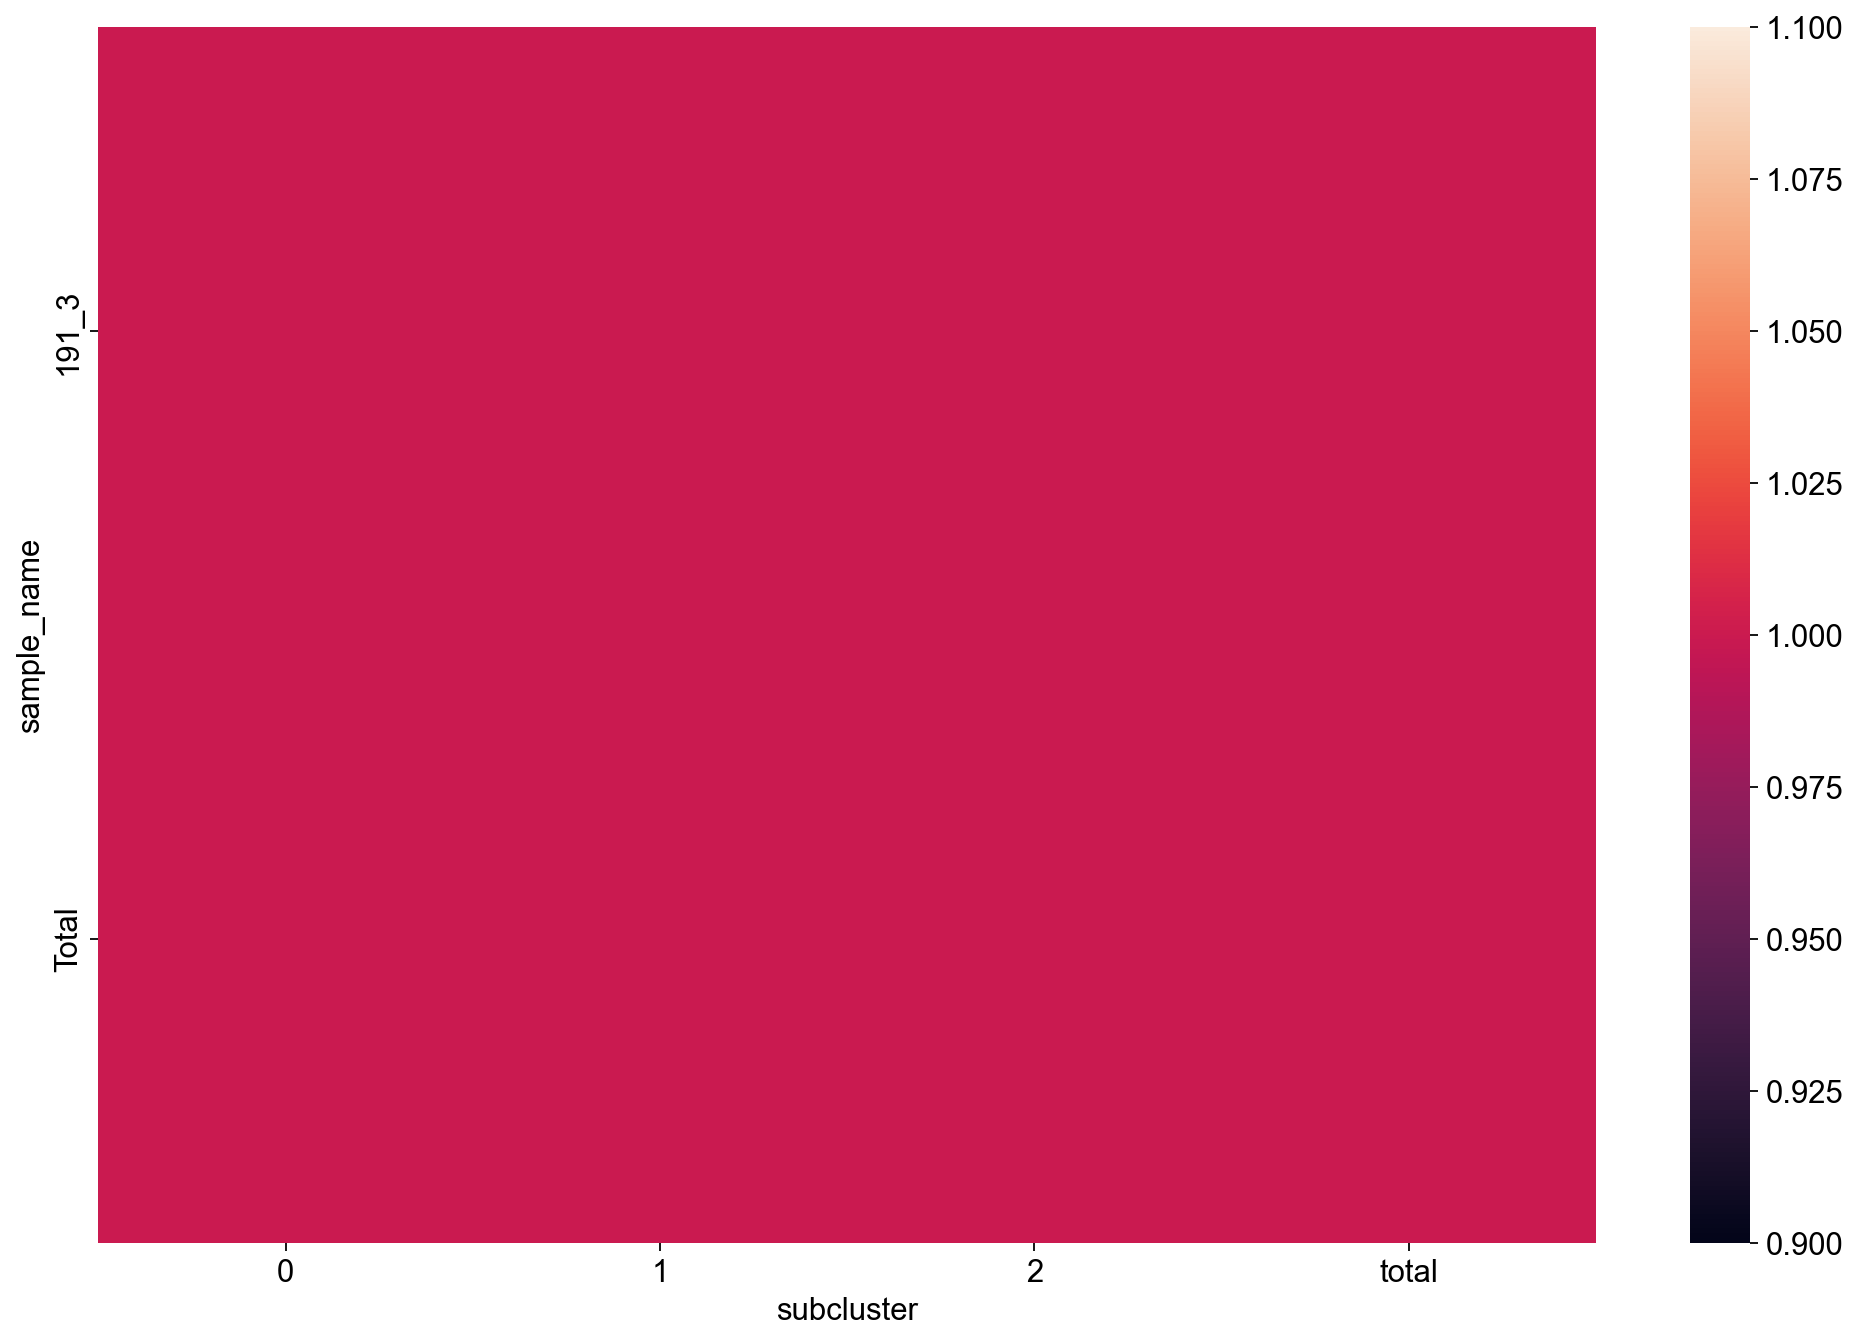

In [22]:
subcluster_22=subcluster(anndata=adata, cluster='22', omit_mark=[], new_clust_name='subcluster', res=0.25, overlay=['191_3'])

In [25]:
subclust_22={
    "0":"CD4T",
    "1":"B",
    "2":"B_T_mix",
}

In [26]:
save_subclust(df=subcluster_22, clust_col='subcluster', dict_annot=subclust_22, filename='subcluster_22')

C:\Users\Marc\AppData\Local\Temp\6/ipykernel_14876/750392560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name_col] = df[clust_col].map(dict_annot).astype('category')


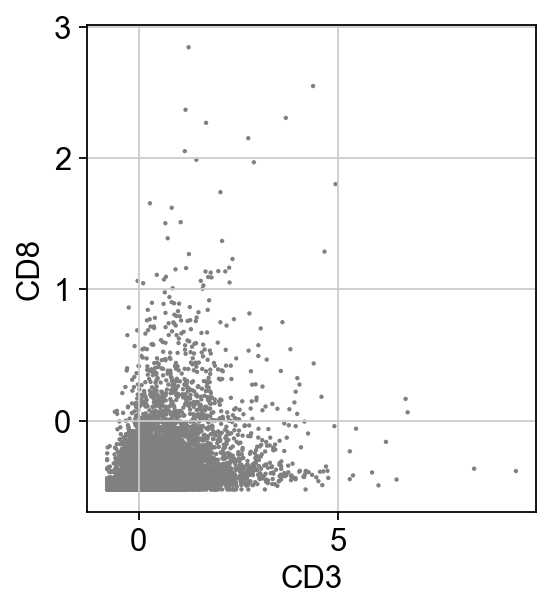

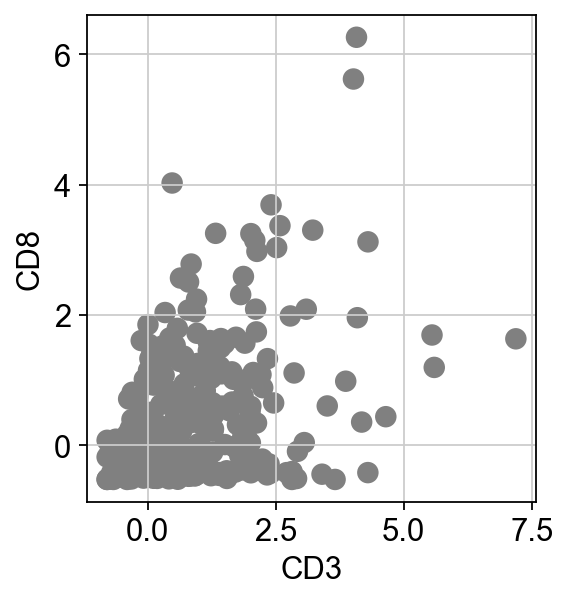

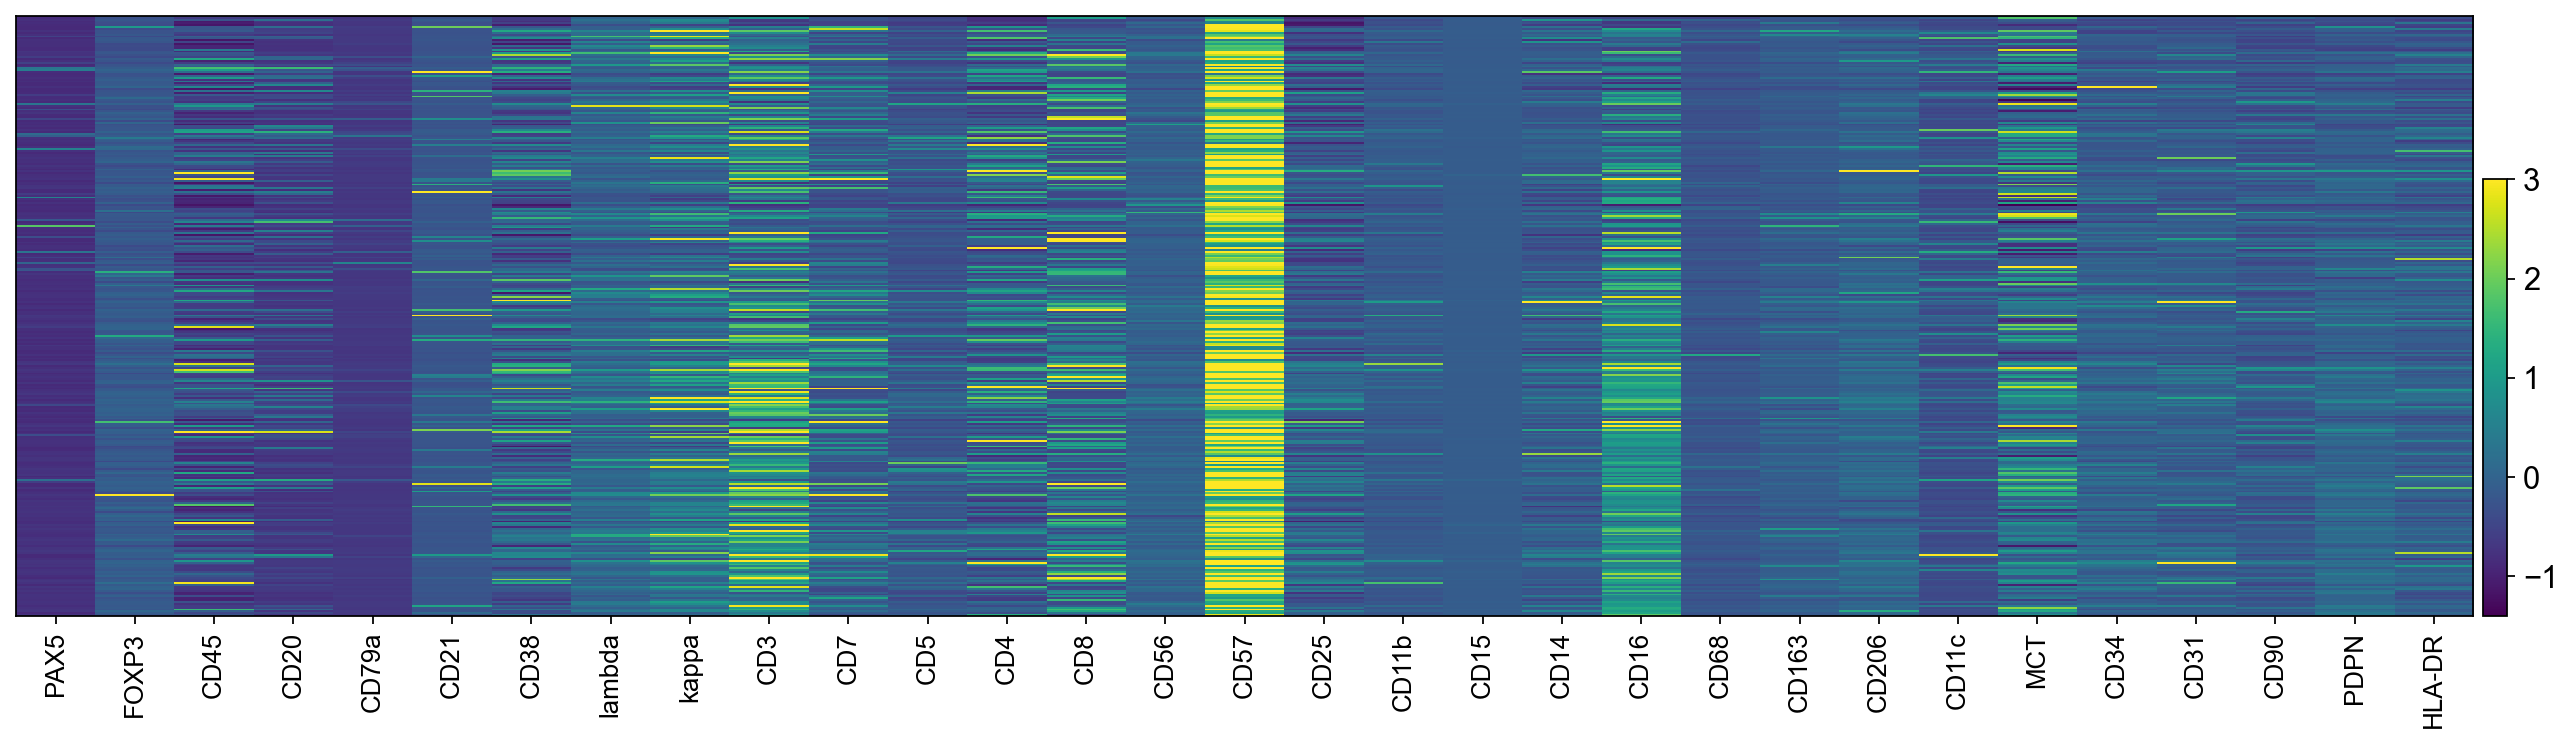

In [23]:
cell_thres(data=adata, cell_type='35', marker_name='CD8', cell_marker='CD3', cell_col='leiden', neg_cell = '2', vmax = 3)

10% = -0.46763214468955994
90% = 1.6376471519470215
median = 0.07642347365617752
mean = 0.394404798746109
threshold = 53.58255451713396
pos_thres = 99.84239558707644
neg_thres = 7.622739018087856



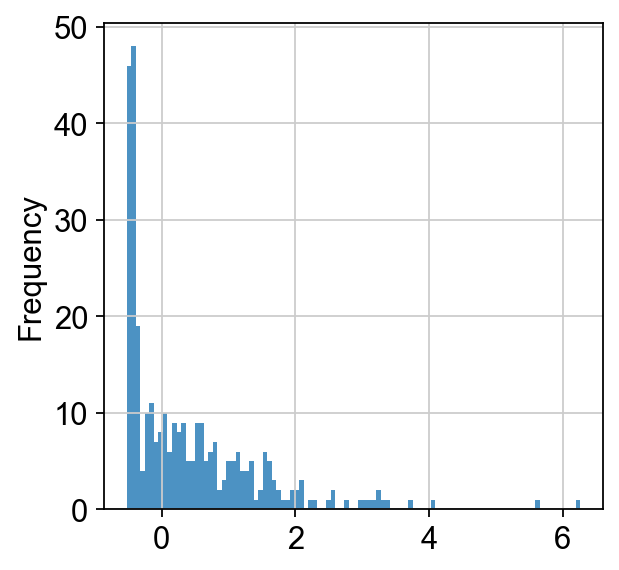

In [27]:
cell_stat(data=adata, cell_type='35', marker_name='CD8', threshold=0, pos_cntrl='0', neg_cntrl='2', cell_col='leiden', log_plot=False)

In [28]:
subcluster_35=cell_split(data=adata, cell_type='35', marker_name='CD8', threshold=0, cell_col='leiden', new_cell_col='subcluster', neg_cat='CD4T', pos_cat='CD8T', overlay=['191_3'])

subcluster
CD4T    149
CD8T    172
Name: region, dtype: int64


In [29]:
filename_subcl='subcluster_35'
subcluster_35.to_csv(r'H:/Marc/Lymphoma_TMA_191_analysis/clustering_output/demonstration_HD/subclusters/subcluster/'+filename_subcl+'.csv')

In [30]:
adata=gather_subclusters(anndata=adata, subcl=['22', '35'], path=r'H:/Marc/Lymphoma_TMA_191_analysis/clustering_output/demonstration_HD/subclusters/subcluster', old_clust_col='leiden', new_clust_col='subcluster', next_clust_col='subcluster2')
print(len(list(adata.obs['subcluster'].unique())))

C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\anndata\_core\anndata.py:801: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
C:\ProgramData\Anaconda3\envs\Scanpy_PAGA_01_22\lib\site-packages\anndata\_core\anndata.py:875: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


54


In [31]:
list(adata.obs['subcluster'].unique())

['28',
 '3',
 '9',
 'B_T_mix',
 '42',
 '14',
 '39',
 '8',
 '18',
 '41',
 'CD4T',
 '40',
 '7',
 '16',
 '23',
 '26',
 '37',
 '31',
 '2',
 '13',
 '27',
 '10',
 '0',
 '1',
 '34',
 '17',
 '12',
 '33',
 '25',
 '15',
 '6',
 'CD8T',
 '30',
 '47',
 '5',
 '36',
 '21',
 '44',
 '29',
 'B',
 '11',
 '20',
 '4',
 '38',
 '52',
 '51',
 '24',
 '45',
 '32',
 '19',
 '43',
 '50',
 '48',
 '49']